In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Konfiguracja

In [8]:
all_filenames = {
    'daily': {
        'pzu': './pzu_01-06-2010_01-01_2015.csv',
        'pxm': './pxm_01-06-2010_01-01_2015.csv',
        'itg': './itg_01-06-2010_01-01_2015.csv'
    },
    'weekly': {
        'pzu': './pzu_01-06-2010_01-01_2015_weekly.csv',
        'pxm': './pxm_01-06-2010_01-01_2015_weekly.csv',
        'itg': './itg_01-06-2010_01-01_2015_weekly.csv'
    },
    'monthly': {
        'pzu': './pzu_01-06-2010_01-01_2015_monthly.csv',
        'pxm': './pxm_01-06-2010_01-01_2015_monthly.csv',
        'itg': './itg_01-06-2010_01-01_2015_monthly.csv'
    },
    'yearly': {
        'pzu': './pzu_01-06-2010_01-01_2015_yearly.csv',
        'pxm': './pxm_01-06-2010_01-01_2015_yearly.csv',
        'itg': './itg_01-06-2010_01-01_2015_yearly.csv'
    },
}

frequency = 'yearly'
filenames = all_filenames[frequency]
phase_col_name = 'Zamkniecie'
date_col_name = 'Data'
date_format = '%Y-%m-%d'
usecols = [date_col_name] + [phase_col_name]
dates = ['2010-06-01', '2012-01-01', '2013-01-01', '2014-01-01']

### Wczytywanie danych

In [9]:
dateparse = lambda x: pd.datetime.strptime(x, date_format)

def csv_file_to_df(filename):
    assert(len(filename) > 0)
    df = pd.read_csv(filename, parse_dates=[date_col_name], date_parser=dateparse, usecols=usecols)
    return df.set_index(date_col_name)

In [10]:
data_frames = dict(((name, csv_file_to_df(filename)) for name, filename in filenames.items()))
assert(len(data_frames) == 3)
data_frames

{'itg':             Zamkniecie
 Data                  
 2010-12-31        79.7
 2011-12-30       114.4
 2012-12-31       184.5
 2013-12-31       322.0
 2014-12-31       154.0, 'pxm':             Zamkniecie
 Data                  
 2010-12-31      185.72
 2011-12-30       79.00
 2012-12-31       31.00
 2013-12-31        6.50
 2014-12-31        3.50, 'pzu':             Zamkniecie
 Data                  
 2010-12-31      21.376
 2011-12-30      20.098
 2012-12-31      30.309
 2013-12-31      34.740
 2014-12-31      40.333}

## Wykresy, przedział czasowy od 2010-06-01 do 2015-01-01

Wybrałem ten sam przedział dla wszystkich akcji, bo z jednej strony ułatwiło mi to analizę zmian ich wartość, a z drugiej wg tego, co wyczytałem w Sieci, na polskim rynku optymalnym jest najczęściej horyzont 3-5 razy dłuższy od długości planowanej inwestycji.

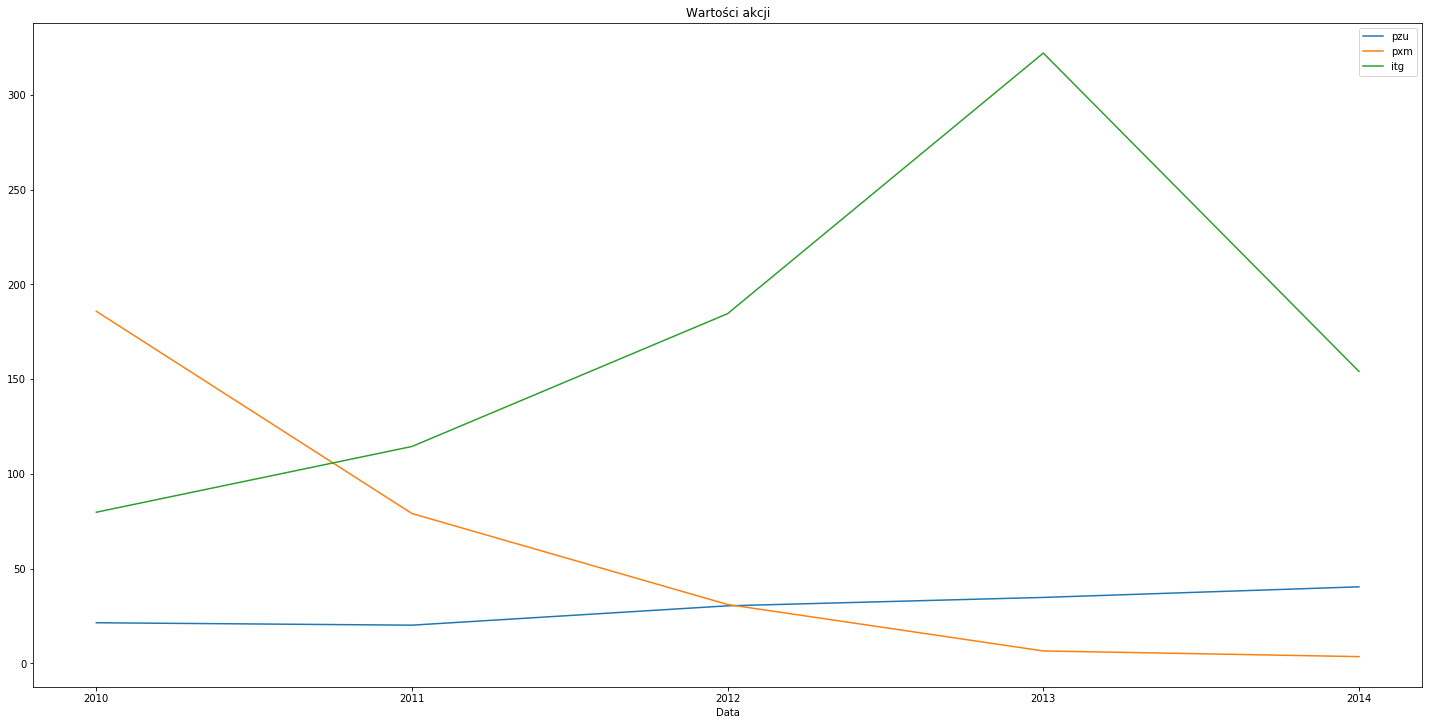

In [11]:
figsize = (20, 10)
kind = 'line'

def plot_data_frames(data_frames):
    for name, df in data_frames.items():
        df[phase_col_name].plot(kind=kind, figsize=figsize, label=name)

    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title("Wartości akcji")
    plt.show()
    

plot_data_frames(data_frames)

### Stopy zwrotu

In [13]:
dfs = {name: {'return': df.loc[df.index >= '2010-06-01'].pct_change()}  for name, df in data_frames.items()}
dfs
mixed_dfs = pd.concat({name: df['return'] for name, df in dfs.items()}, axis=1)
mixed_dfs.corr()

itg        pxm        pzu
               Zamkniecie Zamkniecie Zamkniecie
itg Zamkniecie   1.000000  -0.838187   0.172828
pxm Zamkniecie  -0.838187   1.000000  -0.046404
pzu Zamkniecie   0.172828  -0.046404   1.000000

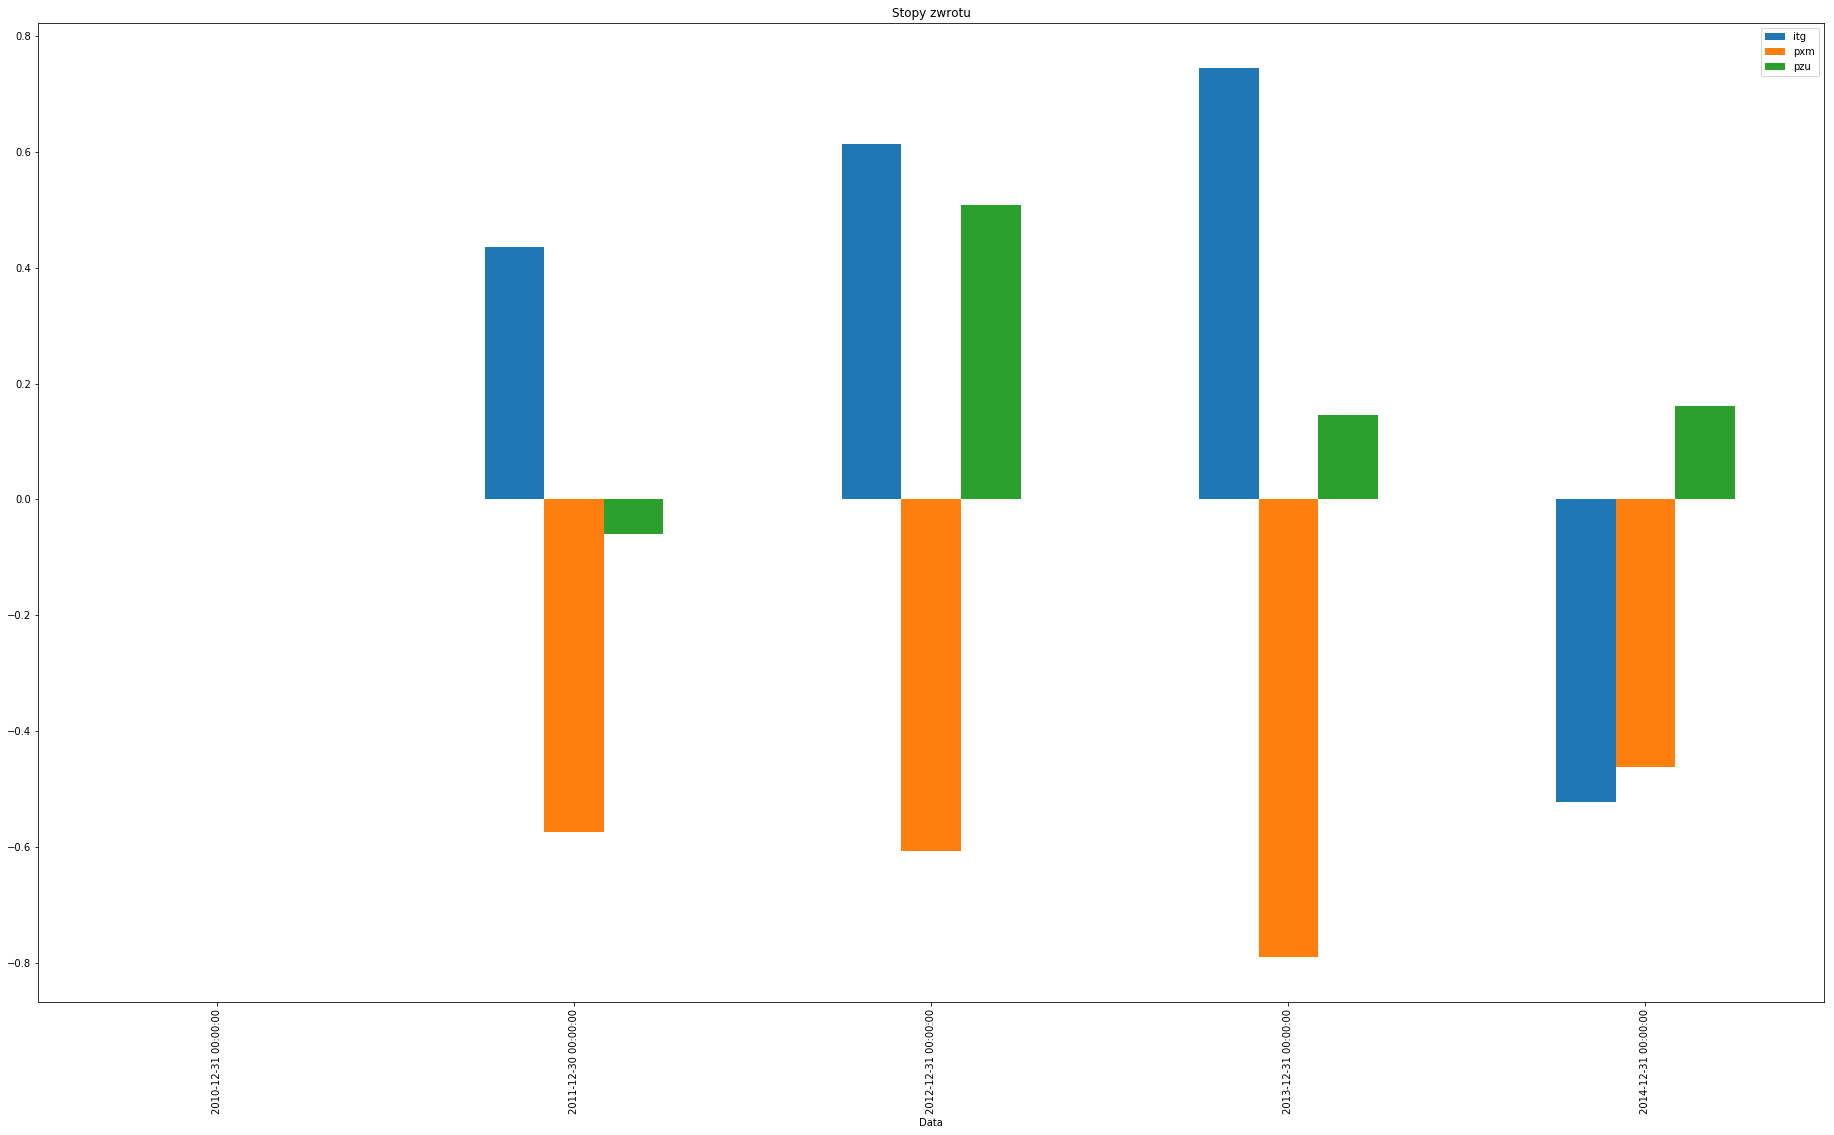

In [14]:
figsize = (32, 18)
kind = 'bar'

return_rates = {name: df.pct_change()['Zamkniecie'] for name, df in data_frames.items()}
pd.concat(return_rates, axis=1).plot(kind=kind, figsize=figsize, title='Stopy zwrotu')

### Wyliczenie parametrów

In [15]:
def get_correlation_matrix(data_frames, start_date):
    dfs = {name: {'return': df.pct_change()}  for name, df in data_frames.items()}
    mixed_dfs = pd.concat({name: df['return'].loc[df['return'].index >= start_date] for name, df in dfs.items()}, axis=1)
    return mixed_dfs.corr()

In [22]:
def calculate_parameters(data_frames, start_date):
    return {
        name: {
            'return': df.pct_change().loc[df.index >= start_date].mean()[0],
            'risk': df.pct_change().loc[df.index >= start_date].std()[0]
        }
        for name, df in data_frames.items()
    }

dates = ['2010-06-01', '2012-01-01', '2013-01-01']
parameters_per_date = {date: calculate_parameters(data_frames, date) for date in dates}
corr_matrices = {date: get_correlation_matrix(data_frames, date) for date in dates}

# Wykresy akcji na podstawie wyliczonych stóp zwrotu i ryzyk

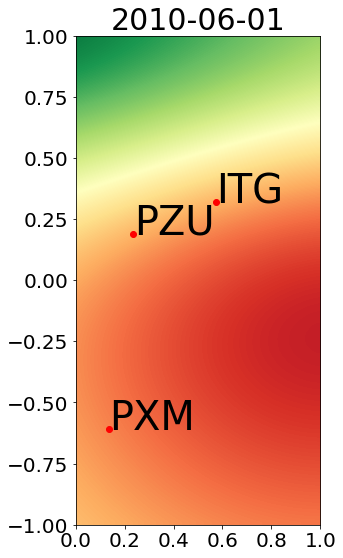

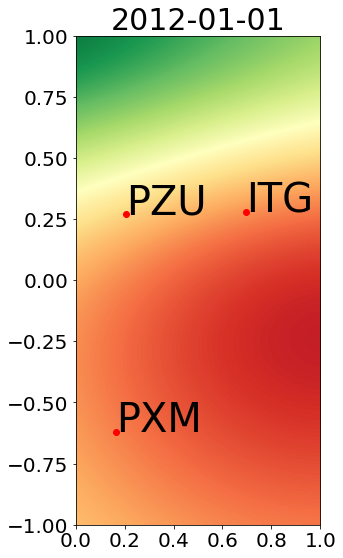

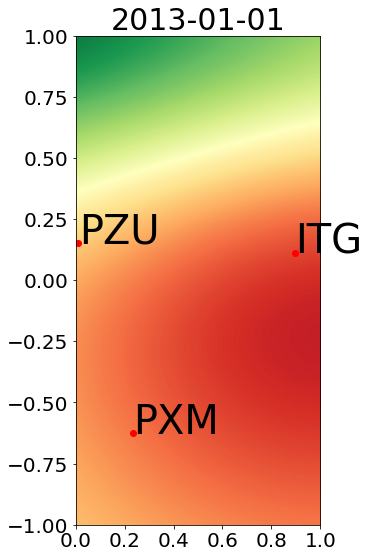

In [53]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

delta = 0.025
x = y = np.arange(-1.0, 1.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 1.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 0.0, 1.0)
Z = Z2 - Z1  # difference of Gaussians


def plot_parameters(parameters_per_date, date):
    assert date in parameters_per_date
    parameters = parameters_per_date[date]
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.title(date, fontsize=30)
    plt.xlim(0, 1)
    plt.ylim(-1, 1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    im = plt.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
                origin='lower', extent=[-1, 1, -1, 1],
                vmax=abs(Z).max(), vmin=-abs(Z).max())
    for name, params in parameters.items():
        assert 'risk' in params
        assert 'return' in params
        plt.plot(params['risk'], params['return'], 'ro')
        ax.annotate(name.upper(), (params['risk'] + 0.002, params['return']), size=40)
    plt.show()

for date in dates:
    plot_parameters(parameters_per_date, date)

plt.show()

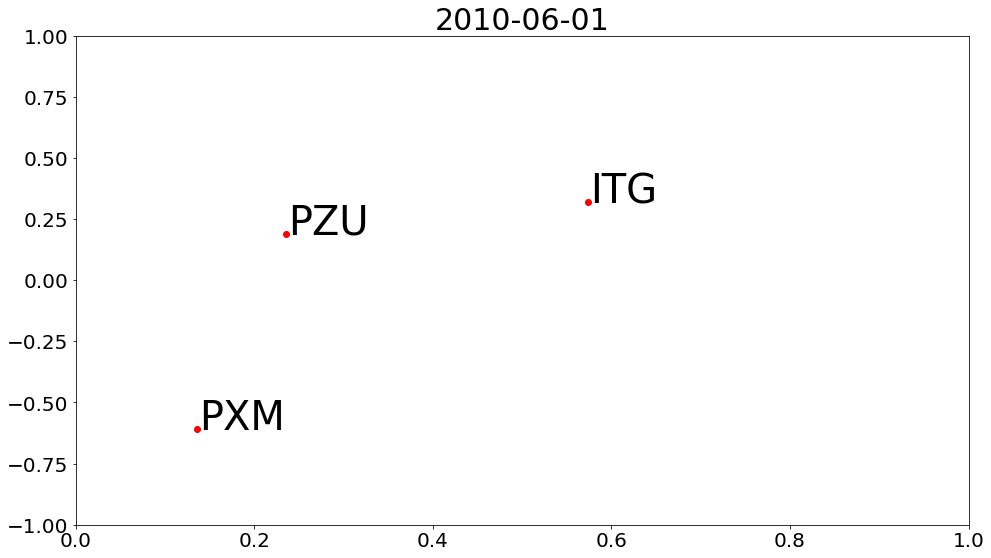

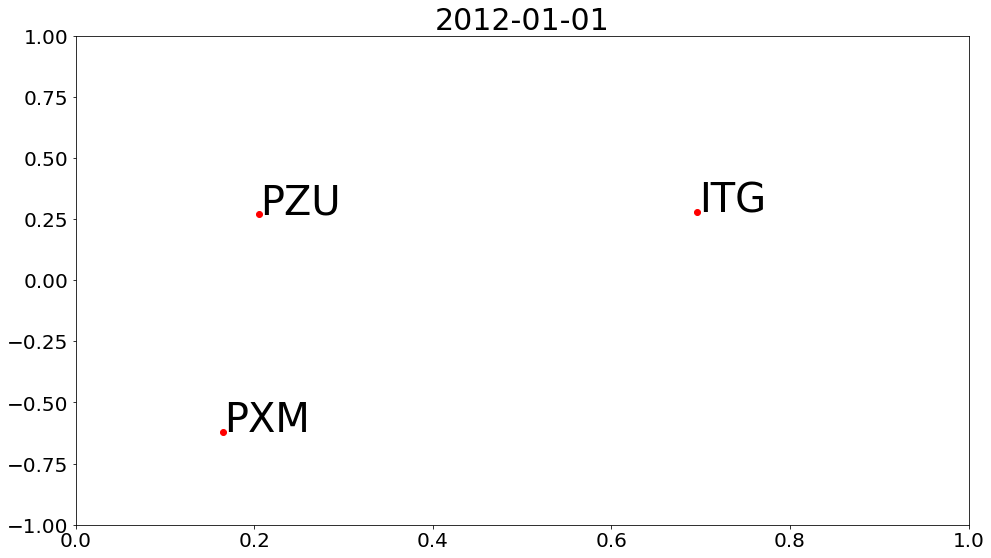

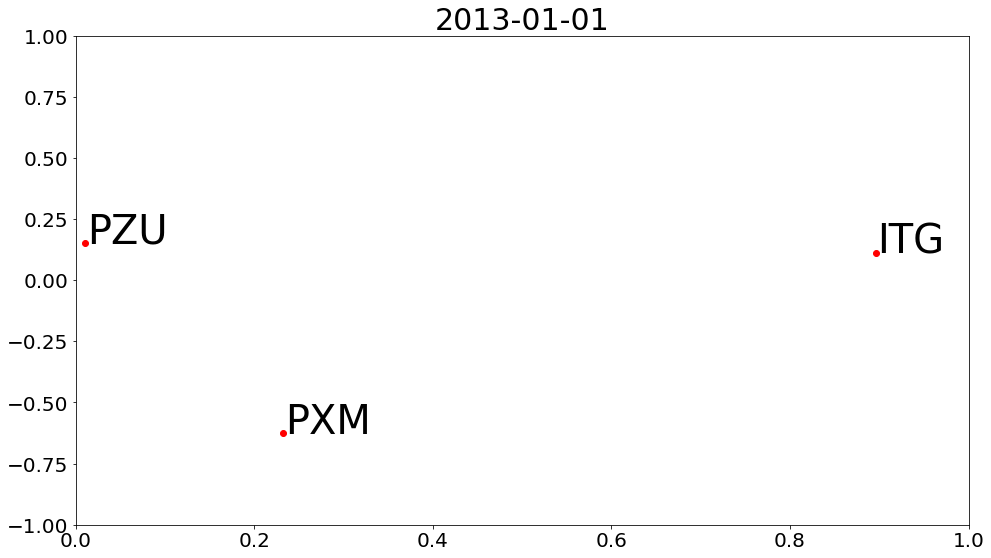

In [23]:
def plot_parameters(parameters_per_date, date):
    assert date in parameters_per_date
    parameters = parameters_per_date[date]
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.title(date, fontsize=30)
    plt.xlim(0, 1)
    plt.ylim(-1, 1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    for name, params in parameters.items():
        assert 'risk' in params
        assert 'return' in params
        plt.plot(params['risk'], params['return'], 'ro')
        ax.annotate(name.upper(), (params['risk'] + 0.002, params['return']), size=40)
    plt.show()

for date in dates:
    plot_parameters(parameters_per_date, date)

### Macierz korelacji

In [24]:
corr_matrices

{'2010-06-01':                       itg        pxm        pzu
                Zamkniecie Zamkniecie Zamkniecie
 itg Zamkniecie   1.000000  -0.838187   0.172828
 pxm Zamkniecie  -0.838187   1.000000  -0.046404
 pzu Zamkniecie   0.172828  -0.046404   1.000000,
 '2012-01-01':                       itg        pxm        pzu
                Zamkniecie Zamkniecie Zamkniecie
 itg Zamkniecie   1.000000  -0.881090   0.382204
 pxm Zamkniecie  -0.881090   1.000000   0.100285
 pzu Zamkniecie   0.382204   0.100285   1.000000,
 '2013-01-01':                       itg        pxm        pzu
                Zamkniecie Zamkniecie Zamkniecie
 itg Zamkniecie        1.0       -1.0       -1.0
 pxm Zamkniecie       -1.0        1.0        1.0
 pzu Zamkniecie       -1.0        1.0        1.0}

In [25]:
parameters_per_date

{'2010-06-01': {'itg': {'return': 0.31791581124274737,
   'risk': 0.57398437295146598},
  'pxm': {'return': -0.60852111296563649, 'risk': 0.13638822324443303},
  'pzu': {'return': 0.18886599917299041, 'risk': 0.23545056508385939}},
 '2012-01-01': {'itg': {'return': 0.2787601866339936,
   'risk': 0.69641087940792645},
  'pxm': {'return': -0.61981865963082783, 'risk': 0.16473255232572245},
  'pzu': {'return': 0.27175022444622271, 'risk': 0.2047844820844576}},
 '2013-01-01': {'itg': {'return': 0.11175916106987155,
   'risk': 0.89590187558606627},
  'pxm': {'return': -0.62593052109181135, 'risk': 0.23248548016679288},
  'pzu': {'return': 0.15359508490298912, 'risk': 0.010466432167316233}}}

In [26]:
def calculate_weighted_params(weights, returns, risks, correlation):
    n = len(weights)
    assert(n > 0)
    weighted_return = np.sum(weights * returns)
    weighted_risk = np.sqrt(np.sum(
            [np.sum([weights[i] * weights[j] * risks[i] * risks[j] * correlation[i, j]
                 for j in range(n)])
         for i in range(n)]))
    return weighted_risk, weighted_return

In [27]:
def calculate_portfolios(returns, risks, correlation, plot_density=10):
    for w1 in np.linspace(0.00, 1.0, plot_density):
        m2 = 1.0 - w1
        for w2 in np.linspace(0.00, m2, plot_density):
            weights = np.array([w1, w2, 1 - w1 - w2])
            assert np.sum(weights) - 1.0 < 10e-4
            yield (tuple(weights), tuple(calculate_weighted_params(weights, returns, risks, correlation)))

In [28]:
def calculate_portfolios_from_date(date, data_frames, plot_density=10):
    keys = data_frames.keys()
    print(keys)
    return list(calculate_portfolios(
        np.array([parameters_per_date[date][k]['return'] for k in keys]),
        np.array([parameters_per_date[date][k]['risk'] for k in keys]),
        corr_matrices[date].as_matrix(),
        plot_density))

In [29]:
def split_portfolios(portfolios):
    portfolios_set = set(portfolios)
    best = lambda x: not any([p[1][0] <= x[1][0] and x[1][1] <= p[1][1] for p in portfolios_set - set([x])])
    optimals = set(filter(best, portfolios))
    return (optimals, portfolios_set - optimals)

In [30]:
def plot_portfolios(portfolios):
    optimals, non_optimals = split_portfolios(portfolios)
    assert len(optimals) > 0
    assert len(non_optimals) > 0
    for k, v in non_optimals:
        plt.plot(*v, 'ro')
    for k, v in optimals:
        plt.plot(*v, 'go')

In [31]:
def plot_portfolios_from_date(date, data_frames, plot_density=10):
    keys = data_frames.keys()
    returns = np.array([parameters_per_date[date][k]['return'] for k in keys])
    risks = np.array([parameters_per_date[date][k]['risk'] for k in keys])

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title(date)
    for name, params in parameters_per_date[date].items():
        plt.plot(params['risk'], params['return'], 'ro')
        ax.annotate(name, (params['risk'], params['return']))
    
    portfolios = tuple(calculate_portfolios(returns, risks, corr_matrices[date].as_matrix(), plot_density))
    plot_portfolios(portfolios)

### Optymalne portfele bez pozycji krótkich, dla akcji ITG, PXM i PZU

In [34]:
import random
density = 10
[random.choice(list(split_portfolios(calculate_portfolios_from_date('2013-01-01', data_frames, density))[0])) for _ in range(2)]

dict_keys(['pzu', 'pxm', 'itg'])
dict_keys(['pzu', 'pxm', 'itg'])


[((1.0, 0.0, 0.0), (0.010466432167316233, 0.15359508490298912)),
 ((1.0, 0.0, 0.0), (0.010466432167316233, 0.15359508490298912))]

### Efficient frontier bez pozycji krótkich, dla akcji ITG, PXM i PZU

dict_keys(['pzu', 'pxm', 'itg'])
2010-06-01
0.347 0.653 0.000 | 0.049 -0.332
0.367 0.633 0.000 | 0.049 -0.316
0.388 0.612 0.000 | 0.050 -0.299
0.388 0.600 0.012 | 0.052 -0.288
0.408 0.592 0.000 | 0.052 -0.283
0.408 0.580 0.012 | 0.055 -0.272
0.429 0.571 0.000 | 0.055 -0.267
0.408 0.568 0.024 | 0.058 -0.261
0.429 0.560 0.012 | 0.058 -0.256
0.449 0.551 0.000 | 0.059 -0.251
0.429 0.548 0.023 | 0.061 -0.245
0.449 0.540 0.011 | 0.061 -0.240
0.469 0.531 0.000 | 0.064 -0.234
0.449 0.529 0.022 | 0.064 -0.230
0.469 0.520 0.011 | 0.066 -0.224
0.449 0.517 0.034 | 0.068 -0.219
0.490 0.510 0.000 | 0.068 -0.218
0.469 0.509 0.022 | 0.069 -0.214
0.490 0.500 0.010 | 0.071 -0.208
0.469 0.498 0.032 | 0.072 -0.204
0.490 0.489 0.021 | 0.073 -0.199
0.469 0.487 0.043 | 0.076 -0.194
0.510 0.480 0.010 | 0.076 -0.192
0.490 0.479 0.031 | 0.077 -0.189
0.510 0.470 0.020 | 0.079 -0.183
0.490 0.469 0.042 | 0.080 -0.179
0.531 0.460 0.010 | 0.082 -0.177
0.510 0.460 0.030 | 0.082 -0.174
0.490 0.458 0.052 | 0.084 -0.170

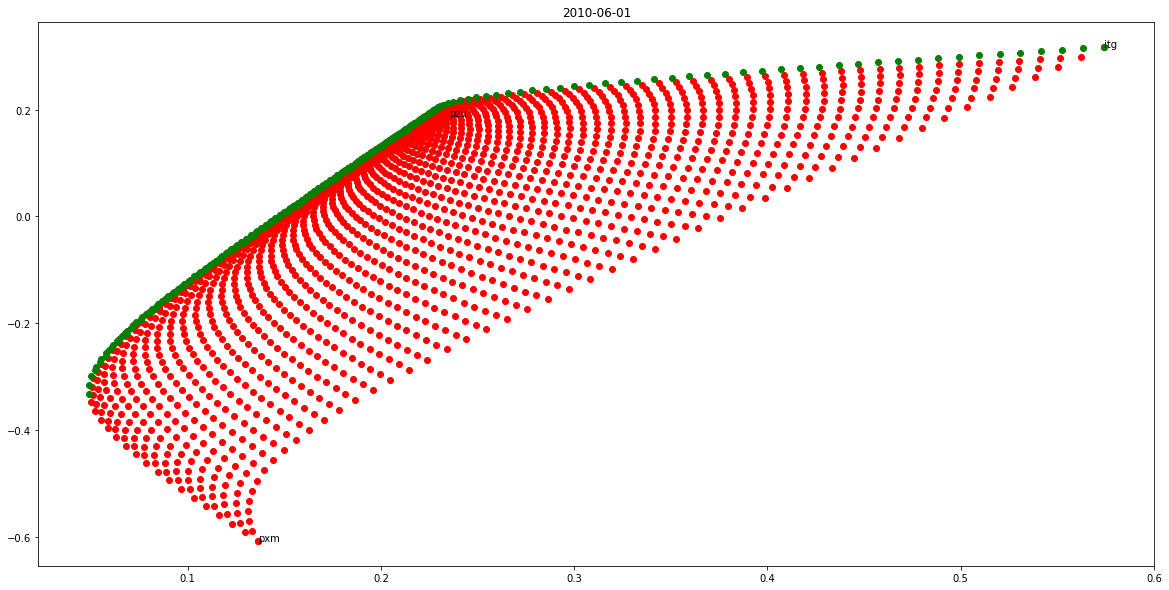

dict_keys(['pzu', 'pxm', 'itg'])
2012-01-01
0.449 0.551 0.000 | 0.045 -0.220
0.469 0.531 0.000 | 0.046 -0.201
0.490 0.510 0.000 | 0.048 -0.183
0.510 0.490 0.000 | 0.051 -0.165
0.531 0.469 0.000 | 0.055 -0.147
0.551 0.449 0.000 | 0.059 -0.129
0.571 0.429 0.000 | 0.064 -0.110
0.592 0.408 0.000 | 0.070 -0.092
0.592 0.400 0.008 | 0.075 -0.085
0.612 0.388 0.000 | 0.075 -0.074
0.612 0.380 0.008 | 0.080 -0.067
0.633 0.367 0.000 | 0.081 -0.056
0.633 0.360 0.007 | 0.086 -0.049
0.653 0.347 0.000 | 0.088 -0.038
0.653 0.340 0.007 | 0.092 -0.031
0.673 0.327 0.000 | 0.094 -0.019
0.673 0.320 0.007 | 0.098 -0.013
0.694 0.306 0.000 | 0.101 -0.001
0.694 0.300 0.006 | 0.104 0.004
0.714 0.286 0.000 | 0.107 0.017
0.714 0.280 0.006 | 0.110 0.022
0.714 0.274 0.012 | 0.113 0.027
0.735 0.265 0.000 | 0.114 0.035
0.735 0.260 0.005 | 0.117 0.040
0.735 0.254 0.011 | 0.119 0.045
0.755 0.245 0.000 | 0.121 0.053
0.755 0.240 0.005 | 0.123 0.058
0.755 0.235 0.010 | 0.126 0.062
0.776 0.224 0.000 | 0.127 0.072
0.776 0.22

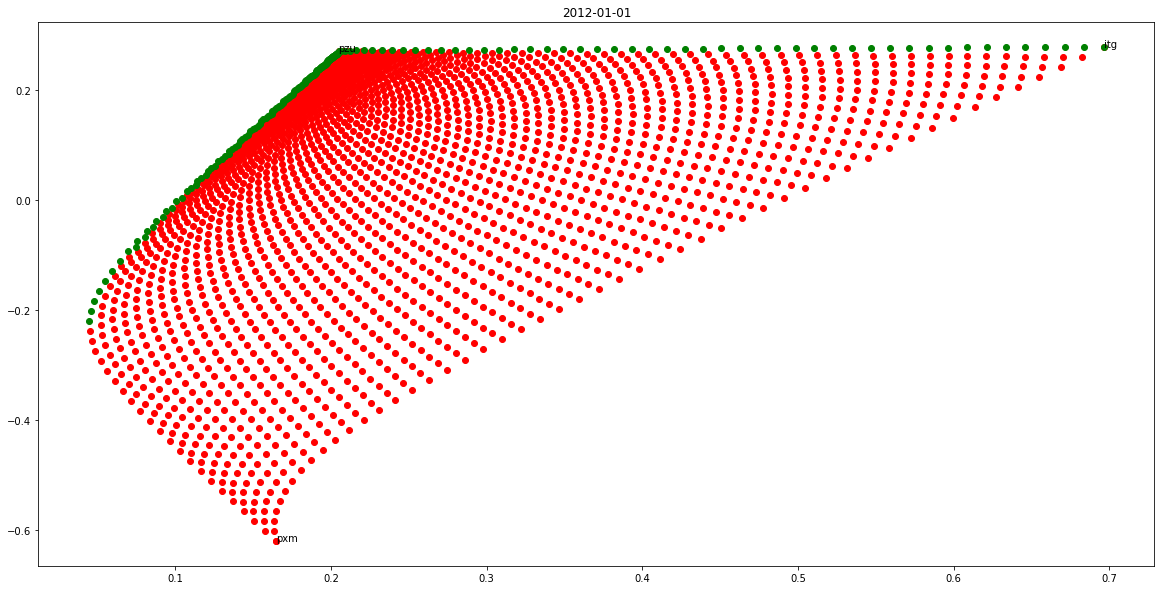

dict_keys(['pzu', 'pxm', 'itg'])
2013-01-01
0.959 0.040 0.001 | 0.000 0.122
0.980 0.012 0.008 | 0.000 0.144
0.980 0.012 0.009 | 0.000 0.144
0.980 0.011 0.009 | 0.001 0.144
0.980 0.011 0.010 | 0.001 0.145
0.980 0.010 0.010 | 0.001 0.145
0.980 0.010 0.010 | 0.001 0.145
0.980 0.010 0.011 | 0.002 0.146
0.980 0.009 0.011 | 0.002 0.146
0.980 0.009 0.012 | 0.002 0.146
0.980 0.008 0.012 | 0.003 0.147
0.980 0.008 0.012 | 0.003 0.147
0.980 0.007 0.013 | 0.003 0.147
0.980 0.007 0.013 | 0.003 0.148
0.980 0.007 0.014 | 0.004 0.148
0.980 0.006 0.014 | 0.004 0.148
0.980 0.006 0.015 | 0.004 0.148
0.980 0.005 0.015 | 0.004 0.149
0.980 0.005 0.015 | 0.005 0.149
0.980 0.005 0.016 | 0.005 0.149
0.980 0.004 0.016 | 0.005 0.150
0.980 0.004 0.017 | 0.006 0.150
0.980 0.003 0.017 | 0.006 0.150
0.980 0.003 0.017 | 0.006 0.151
0.980 0.002 0.018 | 0.006 0.151
0.980 0.002 0.018 | 0.007 0.151
0.980 0.002 0.019 | 0.007 0.152
0.980 0.001 0.019 | 0.007 0.152
0.980 0.001 0.020 | 0.007 0.152
0.980 0.000 0.020 | 0.008 0.

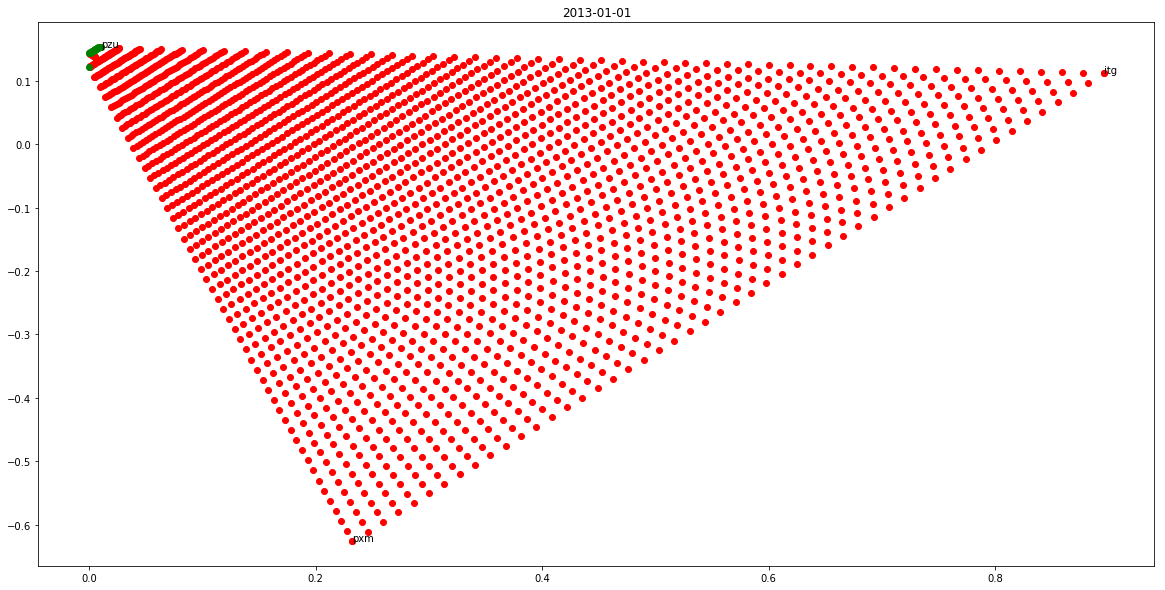

In [35]:
plot_density = 50

def portfolio_cmp(x):
    return (x[1][0], x[1][1])

for date in dates:
    optimal_portfolios_on_date = list(split_portfolios(calculate_portfolios_from_date(date, data_frames, plot_density))[0])
    print(date)
    optimal_portfolios_on_date.sort(key=portfolio_cmp)
    for port in optimal_portfolios_on_date:
        fmt_str = '{:.3f}'
        print(' '.join([fmt_str.format(k) for k in port[0]]) + ' | ' + ' '.join([fmt_str.format(k) for k in port[1]]))
    plot_portfolios_from_date(date, data_frames, plot_density)
    plt.show()